<a href="https://colab.research.google.com/github/PedroC-dev/RelatorioAtividadesPDI/blob/main/deteccao_segmentacao_tumores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

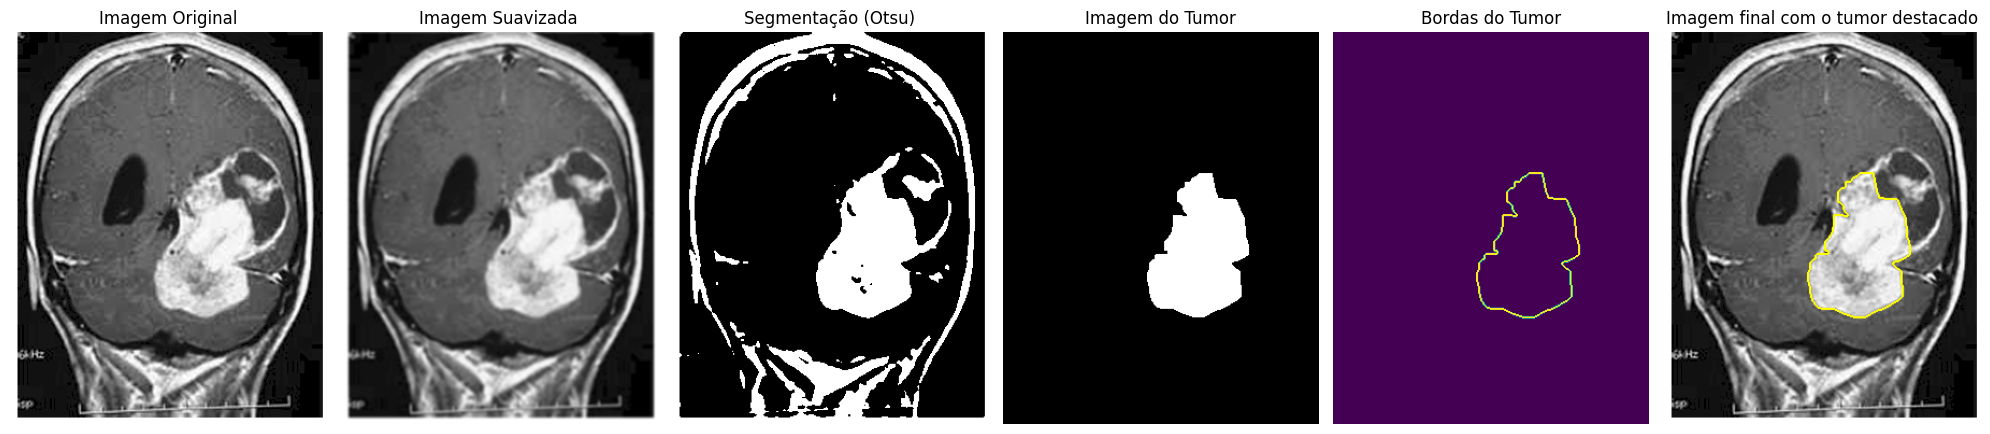

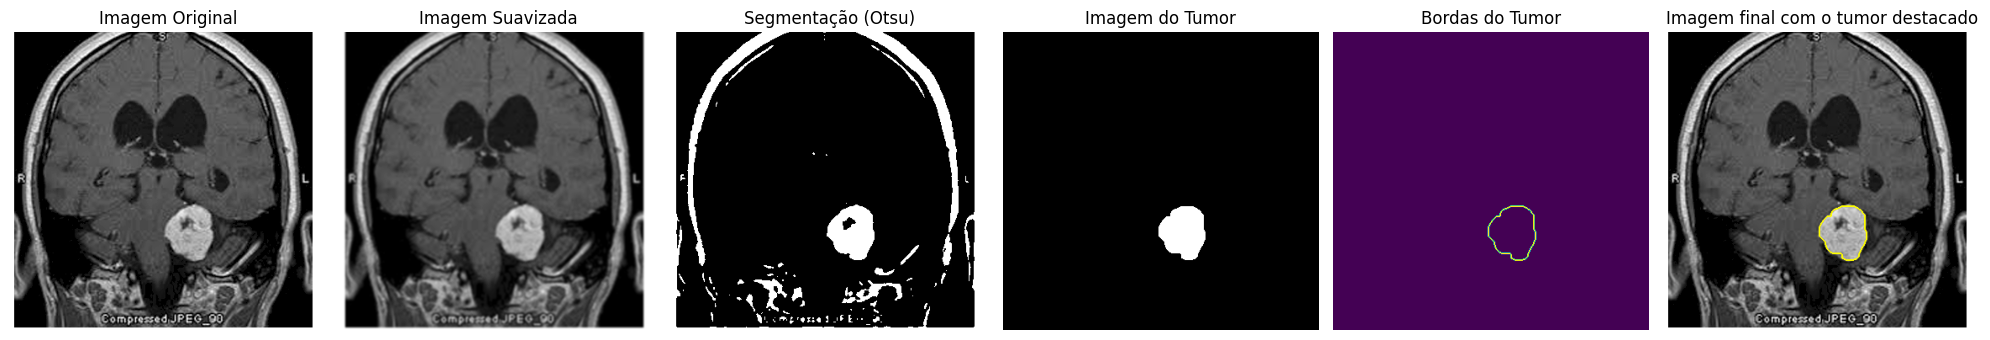

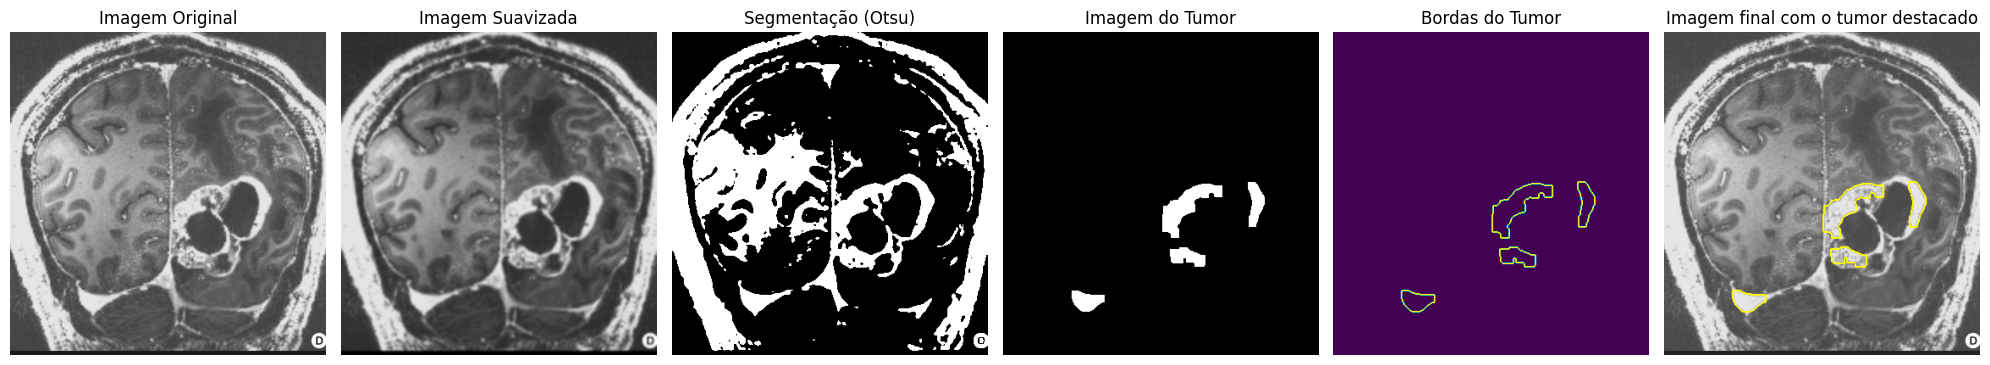

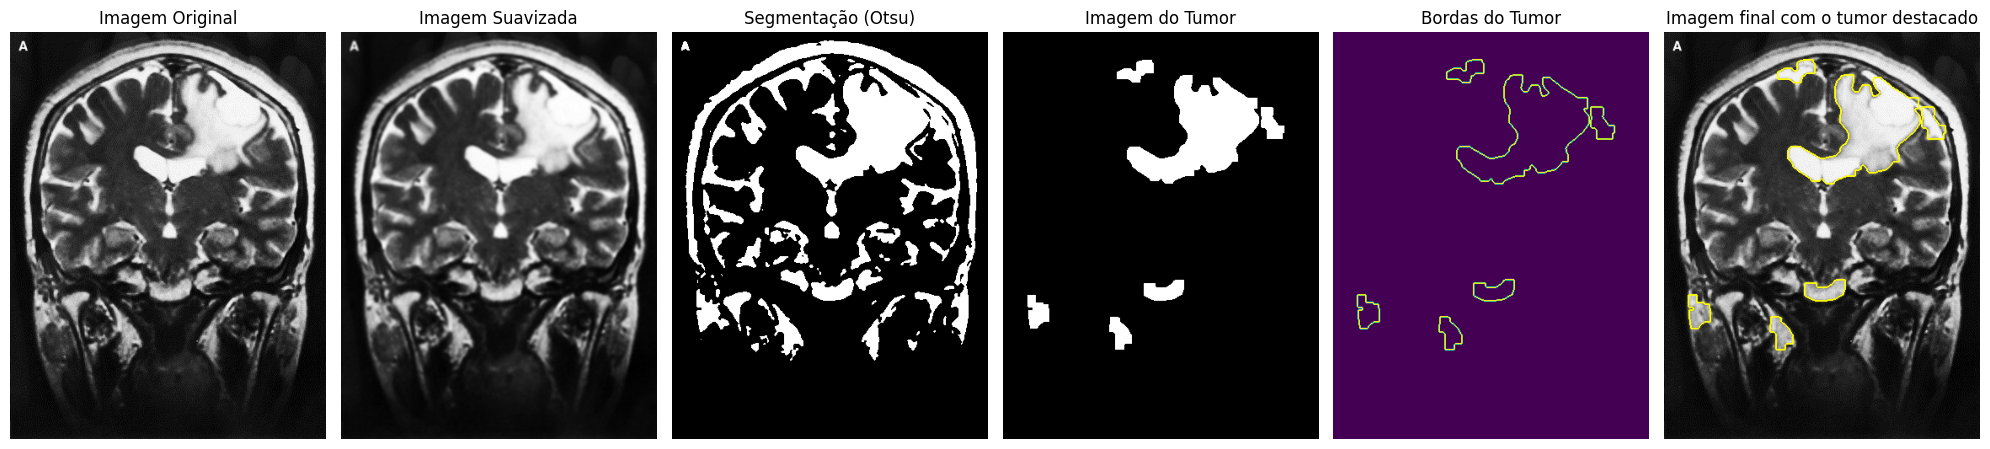

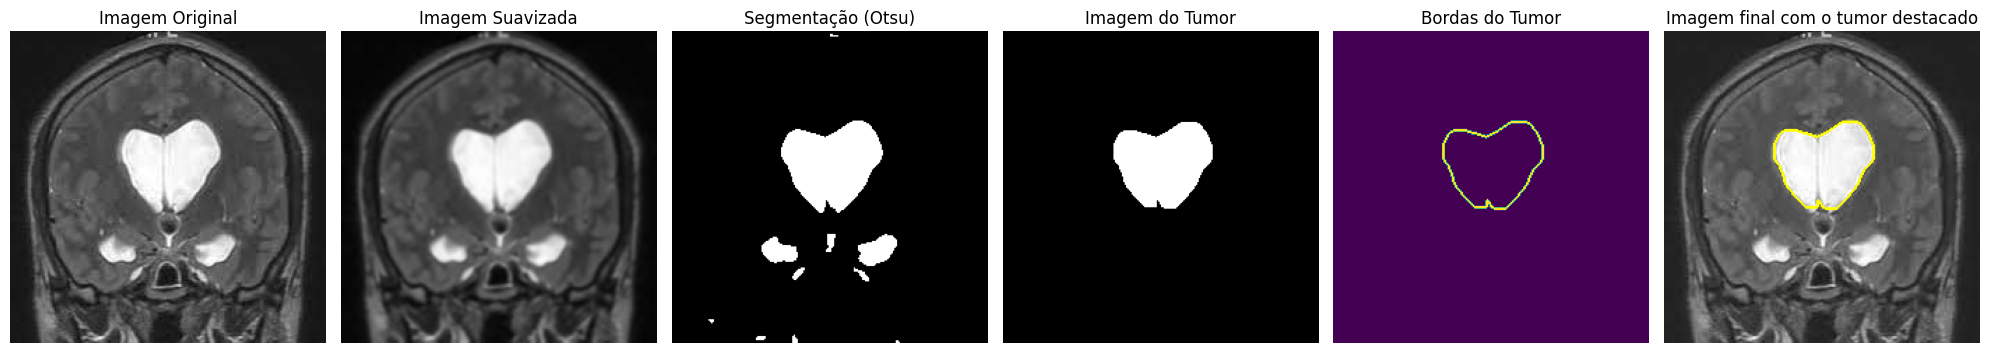

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segmentar_tumor(imagem_path, tamanho_min=500, tamanho_max=20000, kernel_size=5):

    imagem = cv2.imread(imagem_path, cv2.IMREAD_GRAYSCALE)
    if imagem is None:
        raise FileNotFoundError(f"A imagem no caminho {imagem_path} não foi encontrada.")

    # Suavizar a imagem para reduzir ruídos
    imagem_suave = cv2.GaussianBlur(imagem, (5, 5), 0)

    # Aplicar Otsu para binarizar
    _, imagem_bin = cv2.threshold(imagem_suave, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Operações morfológicas na etapa final
    imagem_morfologica = imagem_bin.copy()
    contornos, _ = cv2.findContours(imagem_morfologica, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    altura, largura = imagem_morfologica.shape
    for contorno in contornos:
        area = cv2.contourArea(contorno)
        x, y, w, h = cv2.boundingRect(contorno)

        # Remover bordas externas e regiões próximas ao topo
        if area > tamanho_max or y < 0.05 * altura:
            cv2.drawContours(imagem_morfologica, [contorno], -1, 0, thickness=cv2.FILLED)

    # Aplicar operações morfológicas (erosão e dilatação)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    imagem_erodida = cv2.erode(imagem_morfologica, kernel, iterations=2)
    imagem_dilatada = cv2.dilate(imagem_erodida, kernel, iterations=2)

    # Remover pequenos objetos
    contornos, _ = cv2.findContours(imagem_dilatada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    imagem_final = np.zeros_like(imagem)

    for contorno in contornos:
        area = cv2.contourArea(contorno)
        if tamanho_min < area < tamanho_max:
            cv2.drawContours(imagem_final, [contorno], -1, 255, thickness=cv2.FILLED)

    return {
        "original": imagem,
        "suave": imagem_suave,
        "otsu": imagem_bin,
        "final": imagem_final,
    }

def aplicar_laplaciano_e_destacar_bordas(imagem_original, imagem_tumor):
    # Aplica o operador Laplaciano na imagem do tumor segmentado para obter suas bordas
    # Sobrepõe na imagem original.

    laplaciano = cv2.Laplacian(imagem_tumor, cv2.CV_64F)
    bordas = cv2.convertScaleAbs(laplaciano)

    # Criar uma cópia colorida da imagem original para destacar as bordas
    imagem_destacada = cv2.cvtColor(imagem_original, cv2.COLOR_GRAY2BGR)

    # Sobrepoe as bordas em amarelo
    imagem_destacada[bordas > 0] = [255, 255, 0]

    return bordas, imagem_destacada

def exibir_resultados(imagens):
    for imagem in imagens:
        try:
            resultados = segmentar_tumor(imagem)
            bordas_tumor, imagem_com_bordas = aplicar_laplaciano_e_destacar_bordas(
                resultados['original'], resultados['final']
            )
            # Exibição das imagens processadas
            titulos = ['Imagem Original', 'Imagem Suavizada', 'Segmentação (Otsu)',
                       'Imagem do Tumor', 'Bordas do Tumor', 'Imagem final com o tumor destacado']
            imagens = [resultados['original'], resultados['suave'], resultados['otsu'],
                       resultados['final'], bordas_tumor, imagem_com_bordas]

            plt.figure(figsize=(20, 8))
            for i in range(6):
                plt.subplot(1, 6, i + 1)
                cmap = 'gray' if i < 4 else None
                plt.imshow(imagens[i], cmap=cmap)
                plt.title(titulos[i])
                plt.axis('off')
            plt.tight_layout()
            plt.show()

        except FileNotFoundError as e:
            print(f"Erro ao processar a imagem {imagem}: {e}")

imagens = [
    '/content/Captura_de_tela_2024-12-03_155103.png',
    '/content/Captura_de_tela_2024-12-03_155106.png',
    '/content/Captura_de_tela_2024-12-03_182828.png',
    '/content/1-s2.0-S0899707102004333-gr3a.jpg',
    '/content/images (1).jpg'
]

exibir_resultados(imagens)
